In [27]:
import numpy as np
from keras.preprocessing import image
from keras.applications import inception_v3
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.config.set_visible_devices([], 'GPU')
from PIL import Image


### Define attack

In [28]:

ip_img_path = "elephant.jpg"
hacked_img_path = "adversarial_sample/hacked_ele.png"
diff_img_path = "adversarial_sample/diff.png"
target_class = 47


### Load model

In [29]:
model = inception_v3.InceptionV3()
ip_layer = model.layers[0].input
op_layer = model.layers[-1].output


2025-02-22 13:03:18.848770: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_276/beta/Assign' id:23312 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_276/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_276/beta, batch_normalization_276/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Load the image to hack

In [30]:
img = image.load_img(ip_img_path, target_size=(299, 299))
ip_image = image.img_to_array(img)
ip_image /= 255.
ip_image -= 0.5
ip_image *= 2.

# Add a 4th dimension for batch size (as Keras expects)
ip_image = np.expand_dims(ip_image, axis=0)

# Create a copy of the input image to hack on
hacked_image = np.copy(ip_image)


### Run the attack

In [31]:
cost_function = op_layer[0, target_class]

gradient_function = K.gradients(cost_function, ip_layer)[0]
grab_cost_and_gradients_from_model = K.function([ip_layer, K.learning_phase()], [cost_function, gradient_function])
cost = 0.0
learning_rate = 0.9

while cost < 0.98:
    cost, gradients = grab_cost_and_gradients_from_model([hacked_image, 0])
    
    # Move the hacked image one step further towards fooling the model 
    hacked_image += gradients * learning_rate

    hacked_image = np.clip(hacked_image, -1.0, 1.0)

    print("\033[92m [+] Predicted probability of target class: {:.8}\033[0m".format(cost))


 [+] Predicted probability of target class: 0.0024271298
 [+] Predicted probability of target class: 0.0035159013
 [+] Predicted probability of target class: 0.0060920562
 [+] Predicted probability of target class: 0.014299776
 [+] Predicted probability of target class: 0.076436393
 [+] Predicted probability of target class: 0.89950478
 [+] Predicted probability of target class: 0.99842596


### Save Adversarial Image

In [32]:
hacked_img = hacked_image[0]
hacked_img /= 2.
hacked_img += 0.5
hacked_img *= 255.

hacked_im = image.array_to_img(hacked_img)
hacked_im.save(hacked_img_path)

diff_img = hacked_image[0] - ip_image[0]
diff_img /= 2.
diff_img += 0.5
diff_img *= 255.

diff_im = Image.fromarray(diff_img.astype(np.uint8))
diff_im.save(diff_img_path)


### Show results

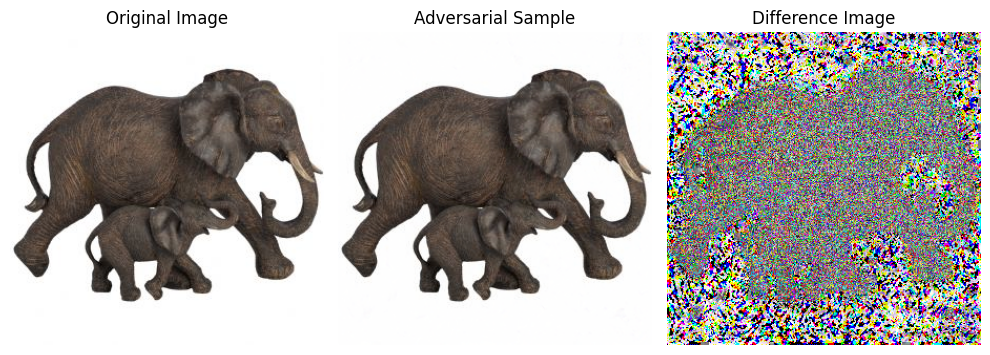

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hacked_im)
plt.title("Adversarial Sample")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff_im)
plt.title("Difference Image")
plt.axis('off')

plt.tight_layout()
plt.show()


### Validate Attack

In [3]:
!~/setup/ai-sec-env/bin/python ./predict_inception.py adversarial_sample/hacked_ele.png

2025-06-08 12:07:05.486658: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 12:07:05.534538: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 12:07:05.534990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-08 12:07:06.264391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Instructions for updating:
Colocations handled automatically by placer.
2025-06-08 12:07:12.605228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-06-08 12:07:13.081892: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normal